In [1]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img)
        plt.title(window_name)
        plt.show()

def display_1_rgb(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()

def display_1_gray(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.show()

def display_1_img(name:str, img, mode:str="rgb"):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if mode == "gray":
        plt.imshow(img, cmap="gray")
    elif mode == "fire":
        plt.imshow(img, cmap="inferno")
    else:
        plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()




def plot_points(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               
               linewidth=2, s=2, alpha=alpha)
    
    return ax

def display_image_with_points(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points(ax, V)

##  Iterative Closest Points

The goal of this task is to estimate the template model.  Using the given image hand.jpg and set of landmark pointshandlandmarks.txt

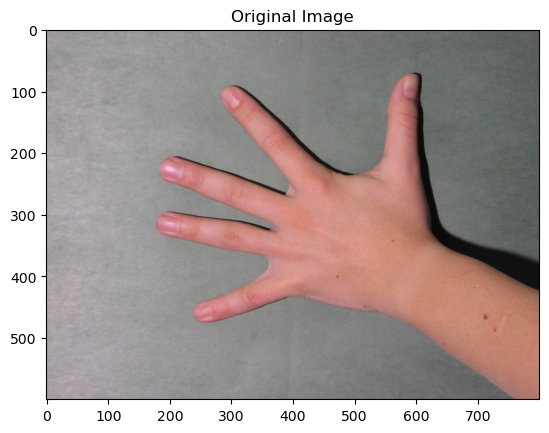

In [2]:
# set image path
path = './data/hand.jpg'
# read imgs
img = cv.imread(path)
display_1_rgb("Original Image", img)

In [3]:


def get_coordinates():
    fpath = './data/hand_landmarks.txt'
    coord_arr = []
    with open(fpath,'r') as f:
        for line in f:
            line = line.replace("(","").replace(")","").strip()
            coord = list(map(int, line.split(",")))
            coord_arr.append(coord)
    return np.array(coord_arr, dtype=np.uint64)

landmark_points = get_coordinates()


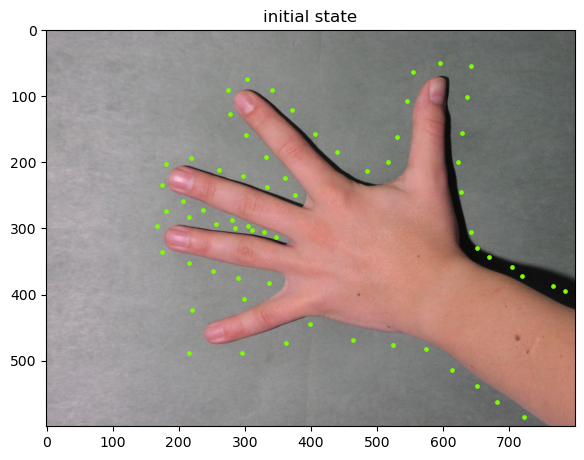

In [4]:
display_image_with_points(img, landmark_points)

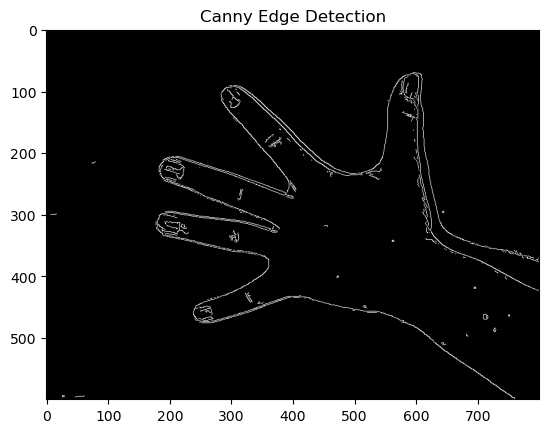

0 255
0.0 1.0


In [5]:
# find edges using Canny edge detector
edges = cv.Canny(img, 50, 100)

display_1_img("Canny Edge Detection", edges, mode="gray")
print(edges.min(), edges.max())

edges = edges.astype(np.float32)
edges /= 255
print(edges.min(), edges.max())

In [6]:
# compute euclidean distance transform for edges 
def euclidean_distance_transform(img):
    """
    Computes euclidean distance transform for given image.
    :param img: input image
    :return: euclidean distance transform of input image
    """
    # create a copy of input image
    img = img.copy()
    # get image shape
    h, w = img.shape
    # create a distance transform image
    dist = np.zeros_like(img)
    # set all non-zero pixels to infinity
    dist[img == 1] = 5
    # set all zero pixels to zero
    dist[img == 0] = 0
    # compute distance transform
    for i in range(1, h):
        for j in range(1, w):
            dist[i, j] = min(dist[i - 1, j - 1], dist[i - 1, j], dist[i, j - 1]) + 1
    return dist

In [7]:
def get_1d_distance_transform(f, n):
    d = np.zeros(n, dtype=np.float64)
    v = np.zeros(n, dtype=np.int32)
    z = np.zeros(n+1, dtype=np.float64)
    z[0] = -np.inf
    z[1] = np.inf
    k = 0
    for q in range(1, n):
        s = ((f[q] + q**2) - (f[v[k]] + v[k]**2))/(2*q - 2*v[k])
        # s = (((f[q] + q) - (f[v[k]] + v[k])))
        while s <= z[k]:
            k -= 1
            s = ((f[q] + q**2) - (f[v[k]] + v[k]**2))/(2*q - 2*v[k])
            # s = (((f[q] + q) - (f[v[k]] + v[k])))
        k += 1
        v[k] = q
        z[k] = s
        z[k+1] = np.inf
    k = 0
    for q in range(n):
        while z[k+1] < q:
            k += 1
        d[q] = (q - v[k])**2 + f[v[k]]
    
    return d

def get_2d_distance_transform(img):
    m, n = img.shape
    d = np.zeros((m, n), dtype=np.float64)
    for i in range(m):
        d[i, :] = get_1d_distance_transform(img[i, :], n)
    for j in range(n):
        d[:, j] = get_1d_distance_transform(d[:, j], m)
    return d


def dt_img(image):
    height = image.shape[0]
    width = image.shape[1]
    # Columns
    for x in range(width):
        f = image[:,x]
        image[:,x] = get_1d_distance_transform(f, height)
    # Rows
    for y in range(height):
        f = image[y,:]
        d = get_1d_distance_transform(f, width)
        image[y,:] = d
    return image


def get_2d_distance_transform_bin(img):
    m, n = img.shape
    k = 6000
    result = np.ones([m, n], dtype=np.float64)*k
    result[img==1]=0
    return dt_img(result)


dist_transf_img = get_2d_distance_transform_bin(edges)

In [8]:
# dist_transf_img = euclidean_distance_transform(edges)

# print(dist_transf_img.min(), dist_transf_img.max())

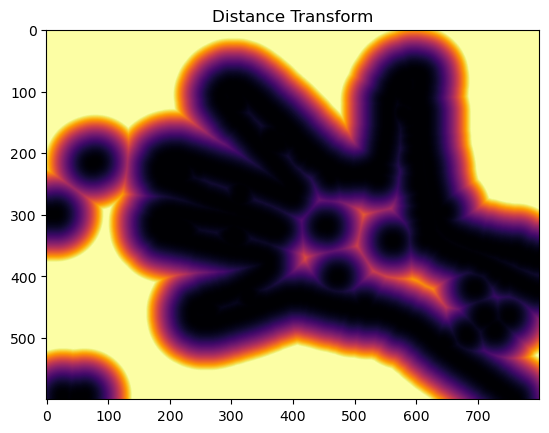

0.0 6000.0


In [9]:
display_1_img("Distance Transform", dist_transf_img, mode="fire")
print(dist_transf_img.min(), dist_transf_img.max())

In [10]:
# calculate the gradient of the distance transform image
gx, gy = np.gradient(dist_transf_img)

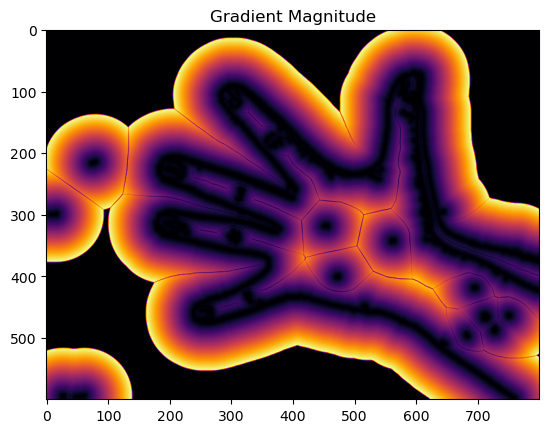

(0.0, 155.1104445226046)

In [11]:
magnitude = np.sqrt(gx**2 + gy**2)
display_1_img("Gradient Magnitude", magnitude, mode="fire")
magnitude.min(), magnitude.max()

In [12]:
# correspondences
def get_correspondences(dist_transf_img, gx, gy):
    magnitude = np.sqrt(gx**2 + gy**2) + 1
    grad_prod = gx*gy + 1
    X = dist_transf_img/magnitude *grad_prod
    return X


    
correspondences = get_correspondences(dist_transf_img, gx, gy)
    

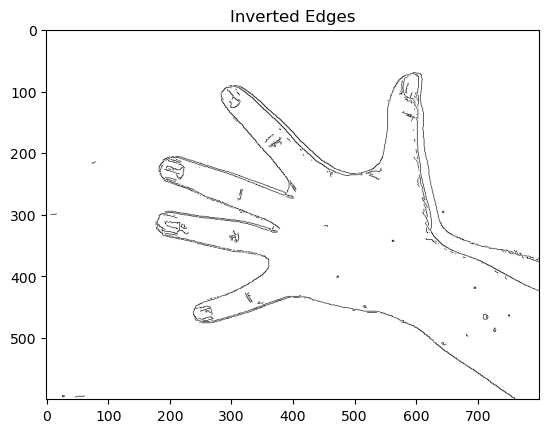

In [13]:
inverted_edges = edges.max() - edges

display_1_img("Inverted Edges", inverted_edges, mode="gray")

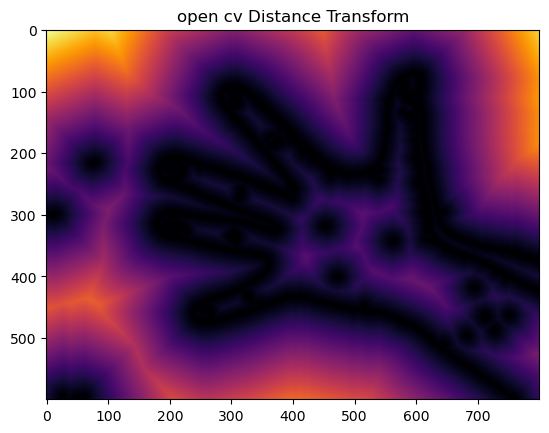

(0.0, 237.76654)

In [14]:
dist = cv.distanceTransform(src=np.uint8(inverted_edges*255), 
                             distanceType=cv.DIST_L2, 
                             maskSize=3)
display_1_img("open cv Distance Transform", dist, mode="fire")
dist.min(), dist.max()

In [15]:
gx_1, gy_1 = np.gradient(dist)

In [16]:
new_lm_points = []
for lm_point in landmark_points:
    i, j = lm_point
    
    D = dist[j, i]
    G_x = gx_1[j, i]
    G_y = gy_1[j, i]
    new_i = i - D*G_x
    new_j = j - D*G_y
    new_lm_points.append([new_i, new_j])

new_lm_points = np.array(new_lm_points)
new_lm_points = np.around(new_lm_points).astype(np.int32)
new_lm_points

array([[716, 593],
       [668, 569],
       [644, 545],
       [599, 521],
       [568, 485],
       [508, 477],
       [444, 469],
       [389, 447],
       [336, 466],
       [278, 480],
       [203, 518],
       [252, 437],
       [316, 415],
       [319, 388],
       [273, 375],
       [237, 372],
       [204, 354],
       [166, 344],
       [174, 314],
       [206, 285],
       [228, 283],
       [265, 290],
       [292, 299],
       [313, 303],
       [349, 312],
       [327, 310],
       [298, 297],
       [275, 289],
       [227, 276],
       [200, 262],
       [173, 243],
       [188, 211],
       [231, 191],
       [270, 208],
       [307, 217],
       [340, 234],
       [385, 247],
       [354, 230],
       [324, 200],
       [291, 164],
       [271, 138],
       [284, 100],
       [320,  73],
       [356,  82],
       [385, 115],
       [413, 150],
       [453, 178],
       [501, 209],
       [536, 218],
       [536, 183],
       [550, 118],
       [572,  80],
       [613,

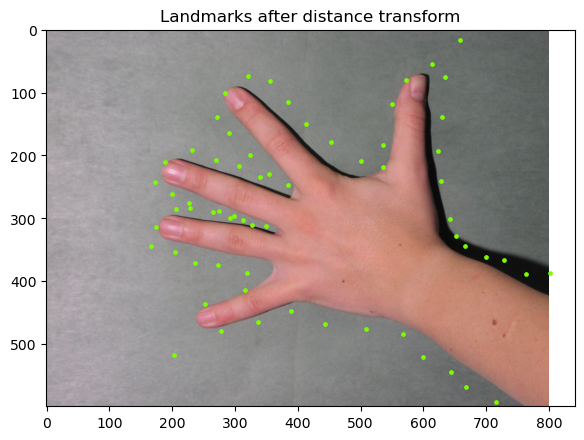

In [17]:
display_image_with_points(img, new_lm_points, title="Landmarks after distance transform")

In [18]:
def get_closest_points(point_cloud_1, point_cloud_2):
    # Find the closest point in point_cloud_2 for each point in point_cloud_1
    closest_points = []
    for point in point_cloud_1:
        distances = np.linalg.norm(point_cloud_2 - point, axis=1)
        closest_point = point_cloud_2[np.argmin(distances)]
        closest_points.append(closest_point)
    return np.array(closest_points)

def get_transformation(point_cloud_1, closest_points):
    # Calculate the transformation that aligns point_cloud_1 and closest_points
    # This can be done using Singular Value Decomposition (SVD)
    centered_points_1 = point_cloud_1 - np.mean(point_cloud_1, axis=0)
    centered_points_2 = closest_points - np.mean(closest_points, axis=0)
    W = np.dot(centered_points_1.T, centered_points_2)
    U, _, Vt = np.linalg.svd(W)
    R = np.dot(U, Vt)
    t = np.mean(closest_points, axis=0) - np.dot(np.mean(point_cloud_1, axis=0), R)
    return R, t

def iterative_closest_point(point_cloud_1, point_cloud_2, max_iterations=50, tolerance=1e-6):
    # Initialize the transformation that aligns the two point clouds
    R = np.eye(point_cloud_1.shape[1])
    t = np.zeros(point_cloud_1.shape[1])

    for i in range(max_iterations):
        # Find the closest points and the transformation that aligns them
        closest_points = get_closest_points(point_cloud_1, point_cloud_2)
        new_R, new_t = get_transformation(point_cloud_1, closest_points)

        # Update the transformation
        R = np.dot(new_R, R)
        t = np.dot(new_R, t) + new_t

        # Calculate the difference between the two point clouds
        difference = np.linalg.norm(point_cloud_1 - closest_points, axis=1)

        # Check if the difference is within the tolerance
        if np.all(difference < tolerance):
            break

    return R, t

[731 577]
[690 554]
[659 529]
[621 506]
[582 474]
[531 470]
[471 462]
[406 439]
[369 468]
[303 483]
[223 484]
[227 419]
[305 402]
[342 378]
[295 370]
[258 360]
[222 349]
[180 332]
[173 293]
[186 270]
[220 279]
[261 289]
[291 294]
[317 298]
[353 308]
[335 300]
[311 292]
[286 282]
[241 268]
[212 255]
[179 230]
[185 199]
[223 190]
[266 206]
[302 216]
[338 232]
[381 244]
[366 217]
[336 187]
[306 154]
[281 122]
[277  85]
[306  68]
[344  85]
[376 115]
[410 151]
[444 179]
[490 206]
[522 192]
[534 154]
[549 100]
[558  55]
[598  42]
[645  46]
[640  93]
[633 147]
[628 192]
[633 237]
[648 298]
[658 320]
[676 334]
[711 349]
[726 363]
[772 377]
[790 385]
[742 568]
[701 546]
[670 521]
[631 498]
[593 467]
[541 462]
[481 456]
[416 433]
[379 462]
[314 478]
[234 479]
[236 414]
[314 397]
[352 372]
[305 365]
[267 356]
[231 344]
[189 328]
[181 289]
[195 266]
[229 274]
[270 284]
[299 289]
[325 292]
[361 302]
[343 294]
[319 287]
[295 277]
[250 263]
[220 250]
[187 226]
[192 195]
[231 185]
[274 201]
[310 211]


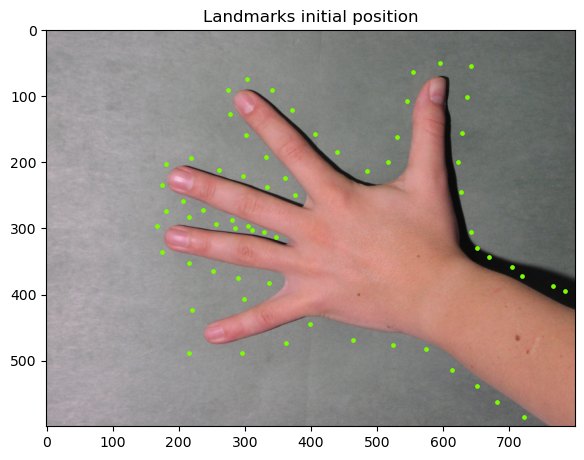

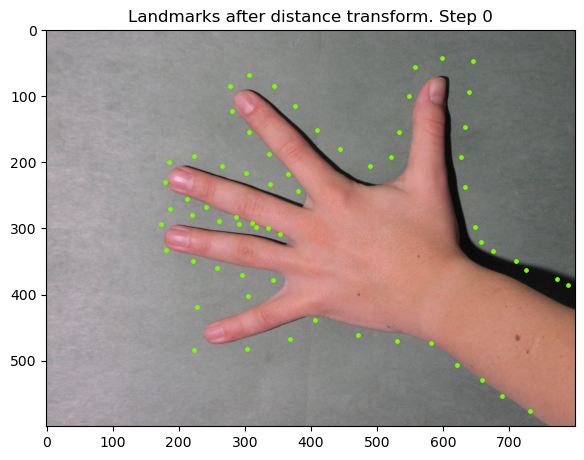

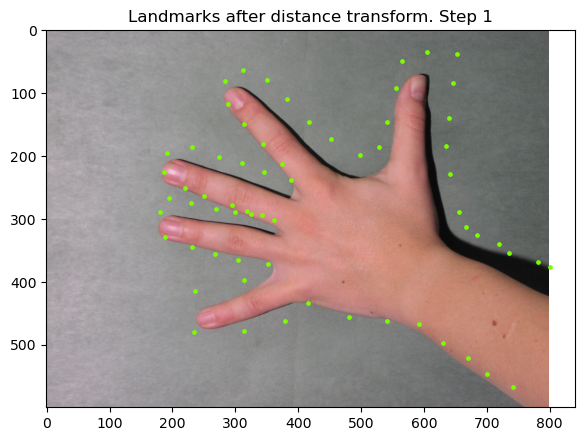

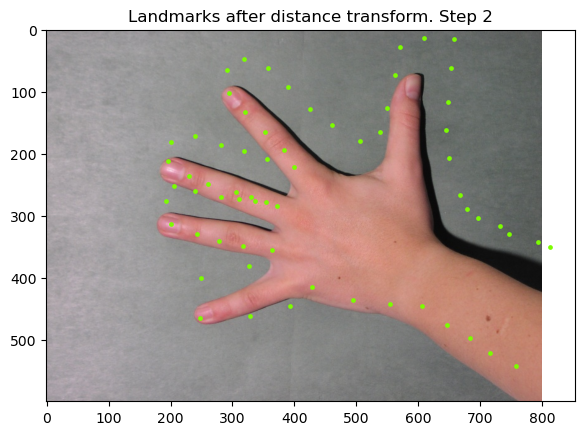

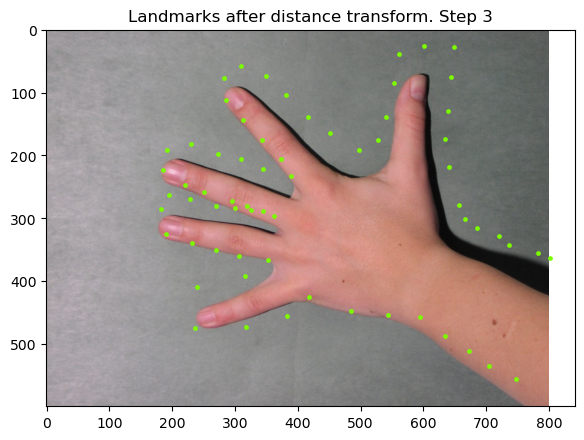

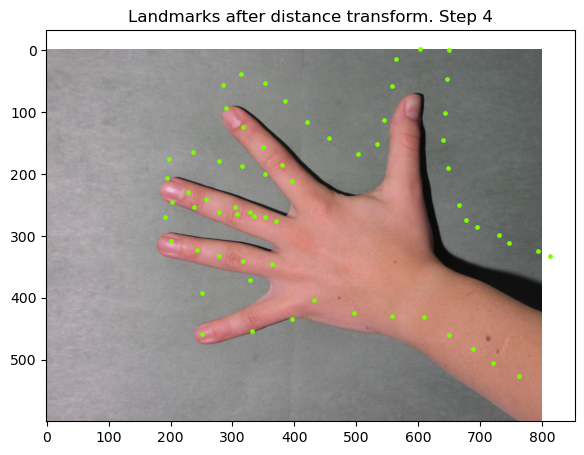

In [34]:
result_points = None
x_lm_points = np.array(landmark_points)
display_image_with_points(img, x_lm_points, title="Landmarks initial position")
R = np.eye(landmark_points.shape[1])
t = np.zeros(landmark_points.shape[1])
for iter in range(5):
    new_lm_points = []
    
    for lm_point in x_lm_points:
        i, j = lm_point
    
        D = dist[j, i]
        G_x = gx_1[j, i]
        G_y = gy_1[j, i]
        new_i = i - D*G_x # according to the lecteur, it should be i - D*G_x, but in this case points "run out" from the edges
        new_j = j - D*G_y # same here
        new_lm_points.append([new_i, new_j])

    x_lm_points = np.array(new_lm_points)
    x_lm_points = np.around(x_lm_points).astype(np.int32)
    x_lm_points = x_lm_points.T
    x_lm_points[0] = np.clip(x_lm_points[0], 0, img.shape[1]-1)
    x_lm_points[1] = np.clip(x_lm_points[1], 0, img.shape[0]-1)
    x_lm_points = x_lm_points.T

    # Find the closest points and the transformation that aligns them
    closest_points = get_closest_points(landmark_points, x_lm_points)
    new_R, new_t = get_transformation(landmark_points, closest_points)

    # Update the transformation
    # R = np.dot(new_R, R)
    # t = np.dot(new_R, t) + new_t
    R = new_R
    t = new_t

    # Calculate the difference between the two point clouds
    difference = np.linalg.norm(landmark_points - closest_points, axis=1)
    # Check if the difference is within the tolerance
    tolerance=1e-6
    if np.all(difference < tolerance):
        break

    result_points = []
    for point in landmark_points:
        
        i, j = point
        new_point = np.around(np.dot(R, point) + t).astype(np.int32)
        print(new_point)

        result_points = list(result_points)
        result_points.append(new_point)
        
        

    result_points = np.array(result_points)

    display_image_with_points(img, result_points, title="Landmarks after distance transform. Step {}".format(iter))


    

In [ ]:
R, t

(array([[ 0.99995069,  0.00993014],
        [-0.00993014,  0.99995069]]),
 array([ 2.57795756, -2.03100596]))

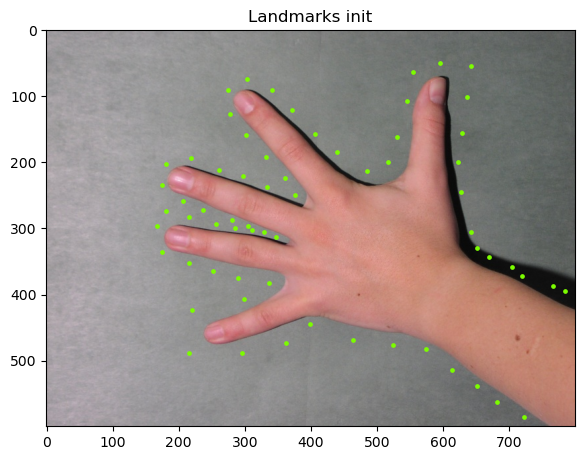

In [ ]:
display_image_with_points(img, landmark_points, title="Landmarks init")